In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from numpy.testing import assert_warns
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
%matplotlib inline


In [3]:
df = pd.read_csv("HR-Employee-Attrition.csv")
print(df.shape)
#check datatype 
print("\033[1m" + "\033[94m" + "Data Types:\n" + 11*"-")
print("\033[30m" + "{}\n".format(df.dtypes))

#check missing values
print("\033[1m" + "\033[94m" + "Sum of null values in each column: \n" + 35*"-")
print("\033[30m" + "{}".format(df.isnull().sum()))

#see what data looks like
df.head(3)

(1470, 25)
Data Types:
-----------
Attrition                   object
Gender                      object
MaritalStatus               object
BusinessTravel              object
OverTime                    object
Department                  object
Age                          int64
DistanceFromHome             int64
EnvironmentSatisfaction      int64
JobInvolvement               int64
JobLevel                     int64
JobSatisfaction              int64
MonthlyIncome                int64
NumCompaniesWorked           int64
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYear        int64
WorkLifeBalance              int64
YearsAtCompany               int64
YearsInCurrentRole           int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
dtype: object

Sum of null values in each column: 
-----------------------------------
Att

,Attrition,Gender,MaritalStatus,BusinessTravel,OverTime,Department,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,Female,Single,Travel_Rarely,Yes,Sales,41,1,2,3,...,3,1,0,8,0,1,6,4,0,5
1,No,Male,Married,Travel_Frequently,No,Research & Development,49,8,3,2,...,4,4,1,10,3,3,10,7,1,7
2,Yes,Male,Single,Travel_Rarely,Yes,Research & Development,37,2,4,2,...,3,2,0,7,3,3,0,0,0,0


In [4]:
#Data Pre-Processing
def attrition_recode(series):
    if series == "Yes":
        return 1
    elif series == "No":
        return 0
df['Attrition'] = df['Attrition'].apply(attrition_recode)

def gender_recode(series):
    if series == "Male":
        return 1
    elif series == "Female":
        return 0
df['Gender'] = df['Gender'].apply(gender_recode)

#MaritalStatus 
def marital_recode(series):
    if series == "Single":
        return 1
    elif series == "Married":
        return 2
    elif series == "Divorced":
        return 3
df['MaritalStatus'] = df['MaritalStatus'].apply(marital_recode)

# Business Travel: change to ordinal categotical feature
bus_travel_map = {"Non-Travel":0, "Travel_Rarely":1, "Travel_Frequently":2}
df["BusinessTravel"] = df["BusinessTravel"].map(bus_travel_map)

def overtime_recode(series):
    if series == "Yes":
        return 1
    elif series == "No":
        return 0
df['OverTime'] = df['OverTime'].apply(overtime_recode)

#. create dummy variables for "Department" feature
df = pd.get_dummies(df, columns = ["Department"], drop_first = True)


In [5]:
#check balance
pos = df[df["Attrition"] == 1].shape[0]
neg = df[df["Attrition"] == 0].shape[0]
print("Positive Examples = {}".format(pos))
print("Negative Example = {}".format(neg))
print("Proportion of Positive to Negaive Examples = {:.2f}%".format((pos/neg)*100))

Positive Examples = 237
Negative Example = 1233
Proportion of Positive to Negaive Examples = 19.22%


In [6]:
X = df.loc[:, df.columns != "Attrition"].values
y = df.loc[:, df.columns == "Attrition"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 1)

In [7]:
from sklearn.utils import resample

#Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                               y_train[y_train == 1],
                               replace = True, # sample with replacement
                               n_samples = X_train[y_train == 0].shape[0], # to match majority class
                               random_state = 1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

#Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                               y_train[y_train == 0],
                               replace = True, # sample with replacement
                               n_samples = X_train[y_train == 1].shape[0], # to match majority class
                               random_state = 1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))

print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (1176, 25) (1176,)
Upsampled shape: (1972, 25) (1972,)
Downsampled shape: (380, 25) (380,)


Text(0.5,1,'PCA on Training Data')

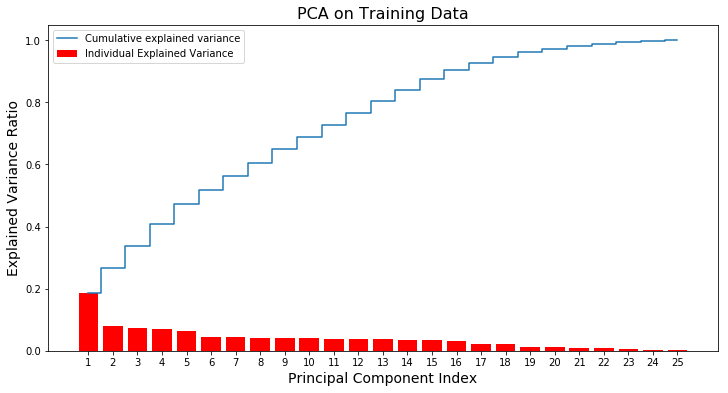

In [8]:
from sklearn.decomposition import PCA

#to see how many principal components needed to explain 90%, 95% and 99% of the variation
pca = PCA(n_components= None, svd_solver = "full")
pca.fit(StandardScaler().fit_transform(X_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize = (12,6))
plt.bar(range(1,26), pca.explained_variance_ratio_, align = "center", color = 'red', 
        label = "Individual Explained Variance")
plt.step(range(1,26), cum_var_exp, where = "mid", label = "Cumulative explained variance")
plt.xticks(range(1, 26))
plt.legend(loc = "best")
plt.xlabel("Principal Component Index", {"fontsize": 14})
plt.ylabel("Explained Variance Ratio", {"fontsize": 14})
plt.title("PCA on Training Data", {"fontsize": 16})

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

#random forest
# Build random forest classifier
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "Downsampled": (X_train_d, y_train_d)}
for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]
    }
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print(f"\033[1m\033[0mThe best hyperparameters for {method} data:")
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])
        
    print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_rf.best_score_ * 100:.2f}%.")

The best hyperparameters for Original data:
criterion :  gini
max_features :  log2
min_samples_leaf :  5
n_estimators :  50
Best 10-folds CV f1-score: 47.60%.
The best hyperparameters for Upsampled data:
criterion :  entropy
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.45%.
The best hyperparameters for Downsampled data:
criterion :  entropy
max_features :  0.4
min_samples_leaf :  5
n_estimators :  50
Best 10-folds CV f1-score: 75.23%.


* **The best hyperparameters for Original data:**
criterion :  gini
max_features :  log2
min_samples_leaf :  5
n_estimators :  50
Best 10-folds CV f1-score: 47.60%.
    
* **The best hyperparameters for Upsampled data:**
criterion :  entropy
max_features :  sqrt
min_samples_leaf :  1
n_estimators :  100
Best 10-folds CV f1-score: 98.45%.
    
* **The best hyperparameters for Downsampled data:**
criterion :  entropy
max_features :  0.4
min_samples_leaf :  5
n_estimators :  50
Best 10-folds CV f1-score: 75.23%.

In [10]:
print(X_train_u.shape, y_train_u.shape)
rf = RandomForestClassifier(criterion="entropy", max_features = "sqrt", min_samples_leaf = 1,
                             n_estimators = 100,random_state=0)
rf.fit(X_train_u, y_train_u)
print(rf.feature_importances_)
y_pred_u = rf.predict(X_train_u)
confusion_matrix(y_train_u, y_pred_u)

(1972, 25) (1972,)
[0.01466539 0.03243473 0.02016114 0.05396029 0.06736235 0.06232493
 0.0452236  0.03268642 0.03144303 0.04149782 0.09772709 0.04440257
 0.05125652 0.00712553 0.03218176 0.0445223  0.05966195 0.03476414
 0.03018693 0.05097389 0.03884498 0.03697797 0.04112834 0.01470891
 0.01377742]


array([[986,   0],
       [  0, 986]])

[[235  12]
 [ 30  17]]


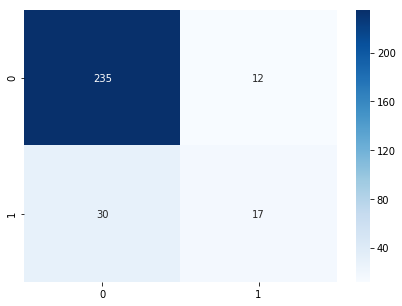

In [11]:
y_pred = rf.predict(X_test)
conf_arr = confusion_matrix(y_test, y_pred)
print(conf_arr)

df_cm = pd.DataFrame(conf_arr, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

[0.       0.048583 1.      ]
[0.         0.36170213 1.        ]
[2 1 0]
0.6565595658540787


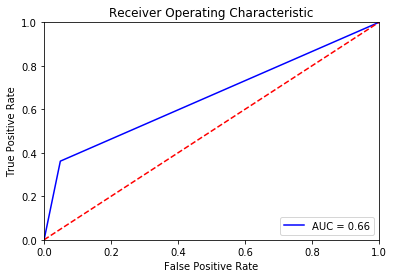

In [12]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresholds)
print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
pip_gb = make_pipeline(StandardScaler(),
                       GradientBoostingClassifier(loss="deviance",
                                                  random_state=123))
hyperparam_grid = {"gradientboostingclassifier__max_features": ["log2", 0.5],
                   "gradientboostingclassifier__n_estimators": [100, 300, 500],
                   "gradientboostingclassifier__learning_rate": [0.001, 0.01, 0.1],
                   "gradientboostingclassifier__max_depth": [1, 2, 3]}
gs_gb = GridSearchCV(pip_gb,
                      param_grid=hyperparam_grid,
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)
gs_gb.fit(X_train_u, y_train_u)
print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in gs_gb.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_gb.best_params_[hyperparam])
print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_gb.best_score_ * 100:.2f}%.")

The best hyperparameters:
-------------------------
learning_rate :  0.1
max_depth :  3
max_features :  0.5
n_estimators :  500
Best 10-folds CV f1-score: 95.67%.


[0.01936017 0.01751402 0.01697159 0.01969244 0.10924454 0.06496986
 0.03441455 0.03320979 0.01950021 0.03225462 0.16891652 0.04510744
 0.06003052 0.00186257 0.03007108 0.03358436 0.0467935  0.04979396
 0.02486241 0.05412623 0.03551136 0.02219807 0.04073072 0.01083801
 0.00844147]
[[221  26]
 [ 16  31]]


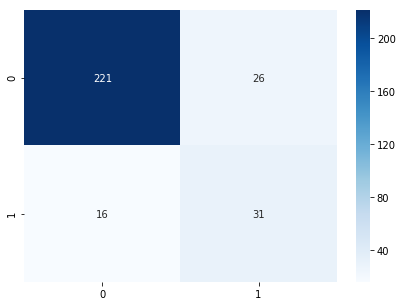

In [14]:
gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, max_features = 0.5,
                             n_estimators = 500)
gb.fit(X_train_u, y_train_u)
print(gb.feature_importances_)
y_pred_u = gb.predict(X_train_u)
confusion_matrix(y_train_u, y_pred_u)

y_pred = gb.predict(X_test)
conf_arr = confusion_matrix(y_test, y_pred)
print(conf_arr)

df_cm = pd.DataFrame(conf_arr, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

[0.         0.10526316 1.        ]
[0.         0.65957447 1.        ]
[2 1 0]
0.7771556550951847


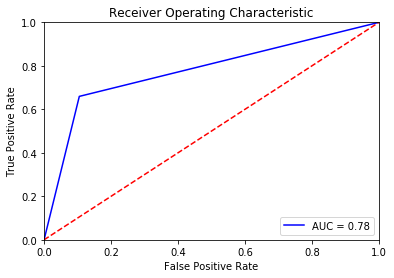

In [15]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresholds)
print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
#Support Vector Machine
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel="poly",
                            degree=5,
                            coef0=10,
                            probability=True))
clf_svc.fit(X_train, y_train)
svc_cv_scores = cross_val_score(clf_svc,
                                X=X_train,
                                y=y_train,
                                scoring="f1",
                                cv=10,
                                n_jobs=-1)
# Print CV
print(f"\033[1m\033[94mThe 10-folds CV f1-score is: {np.mean(svc_cv_scores) * 100:.2f}%")

The 10-folds CV f1-score is: 43.64%


In [17]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)
gs_knn = GridSearchCV(pip_knn,
                      param_grid={"kneighborsclassifier__n_neighbors": list(range(1,20)),
                                  "kneighborsclassifier__weights": ["uniform", "distance"]},
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)
gs_knn.fit(X_train_u, y_train_u)
print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in gs_knn.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_knn.best_params_[hyperparam])
print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_knn.best_score_) * 100))

The best hyperparameters:
-------------------------
n_neighbors :  1
weights :  uniform
Best 10-folds CV f1-score: 95.63%.


[[211  36]
 [ 41   6]]


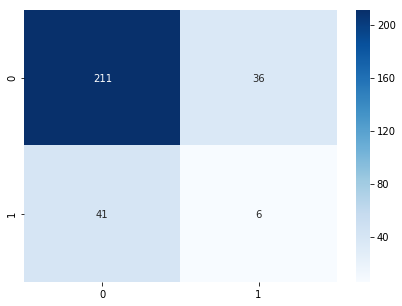

In [18]:
knn = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform', algorithm = 'auto')
knn.fit(X_train_u, y_train_u)

y_pred_u = knn.predict(X_train_u)
confusion_matrix(y_train_u, y_pred_u)

y_pred = knn.predict(X_test)
conf_arr = confusion_matrix(y_test, y_pred)
print(conf_arr)

df_cm = pd.DataFrame(conf_arr, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

[0.         0.14574899 1.        ]
[0.         0.12765957 1.        ]
[2 1 0]
0.490955293306917


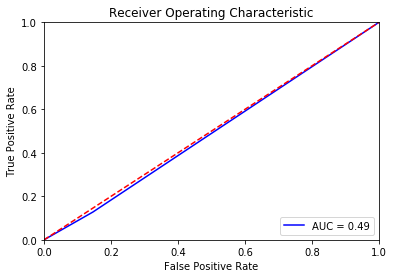

In [19]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresholds)
print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
# Logistic Regression
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight="balanced"))
hyperparam_range = np.arange(0.5, 20.1, 0.5)
hyperparam_grid = {"logisticregression__penalty": ["l1", "l2"],
                   "logisticregression__C":  hyperparam_range,
                   "logisticregression__fit_intercept": [True, False]
                  }
gs_logmodel = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring="accuracy",
                           cv=2,
                           n_jobs=-1)
gs_logmodel.fit(X_train_u, y_train_u)
print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in gs_logmodel.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_logmodel.best_params_[hyperparam])
print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_logmodel.best_score_ * 100:.2f}%.")

The best hyperparameters:
-------------------------
C :  0.5
fit_intercept :  True
penalty :  l1
Best 10-folds CV f1-score: 75.81%.


[[180  67]
 [  8  39]]


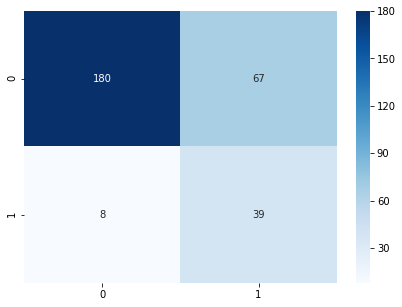

In [21]:
lr = LogisticRegression(C = 0.5, fit_intercept = True, penalty = 'l1')
lr.fit(X_train_u, y_train_u)

y_pred_u = lr.predict(X_train_u)
confusion_matrix(y_train_u, y_pred_u)

y_pred = lr.predict(X_test)
conf_arr = confusion_matrix(y_test, y_pred)
print(conf_arr)

df_cm = pd.DataFrame(conf_arr, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

[0.         0.27125506 1.        ]
[0.         0.82978723 1.        ]
[2 1 0]
0.7792660866569041


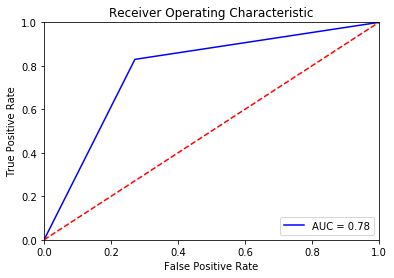

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresholds)
print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()